In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
#import tensorflow as tf
import numpy as np
import pandas as pds
import SimpleITK as sitk
from matplotlib import pyplot as plt
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage
import math
from skimage.filters import threshold_mean
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage
import cv2
import math




/tmp/ipykernel_3018104/2419735581.py:7: DeprecationWarning: Please use `map_coordinates` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import map_coordinates
/tmp/ipykernel_3018104/2419735581.py:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
/tmp/ipykernel_3018104/2419735581.py:12: DeprecationWarning: Please use `map_coordinates` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import map_coordinates
/tmp/ipykernel_3018104/2419735581.py:13: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [3]:
# Reading- Image
#-|path of the data
ct_path='/home/bori/segmentation-pancreas-post-operative/nnUNetFrame/dataset/nnUNet_raw/Dataset001_Postoperative/imagesTr/Image_Recidief1_0000.nii.gz'
ct_label_path='/home/bori/segmentation-pancreas-post-operative/nnUNetFrame/dataset/nnUNet_raw/Dataset001_Postoperative/labelsTr/Image_Recidief1.nii.gz'

# CT
img_sitk  = sitk.ReadImage(ct_path, sitk.sitkFloat32) # Reading CT
image     = sitk.GetArrayFromImage(img_sitk) #Converting sitk_metadata to image Array
# Mask
mask_sitk = sitk.ReadImage(ct_label_path,sitk.sitkInt32) # Reading CT
mask      = sitk.GetArrayFromImage(mask_sitk)#Converting sitk_metadata to image Array

print('CT Shape={}'.format(image.shape))
print('CT Mask Shape={}'.format(mask.shape))

#----Lets plot 
f, axarr = plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(np.squeeze(image[100, :, :]), cmap='gray',origin='lower');
axarr[0].set_ylabel('Axial View',fontsize=14)
axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[0].set_title('CT',fontsize=14)

axarr[1].imshow(np.squeeze(mask[100, :, :]), cmap='jet',origin='lower');
axarr[1].axis('off')
axarr[1].set_title('Mask',fontsize=14)

axarr[2].imshow(np.squeeze(image[100, :, 73]), cmap='gray',alpha=1,origin='lower');
axarr[2].imshow(np.squeeze(mask[100, :, 73]),cmap='jet',alpha=0.5,origin='lower');
axarr[2].axis('off')
axarr[2].set_title('Overlay',fontsize=14)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:97:
sitk::ERROR: The file "/home/bori/segmentation-pancreas-post-operative/nnUNetFrame/dataset/nnUNet_raw/Dataset001_Postoperative/imagesTr/Image_Recidief1_0000.nii.gz" does not exist.

In [7]:
def normalise(image):
    # normalise and clip images -1000 to 800
    np_img = image
    np_img = np.clip(np_img, -1000., 800.).astype(np.float32)
    return np_img


def whitening(image):
    """Whitening. Normalises image to zero mean and unit variance."""

    image = image.astype(np.float32)

    mean = np.mean(image)
    std = np.std(image)

    if std > 0:
        ret = (image - mean) / std
    else:
        ret = image * 0.
    return ret


def normalise_zero_one(image):
    """Image normalisation. Normalises image to fit [0, 1] range."""

    image = image.astype(np.float32)

    minimum = np.min(image)
    maximum = np.max(image)

    if maximum > minimum:
        ret = (image - minimum) / (maximum - minimum)
    else:
        ret = image * 0.
    return ret


def normalise_one_one(image):
    """Image normalisation. Normalises image to fit [-1, 1] range."""

    ret = normalise_zero_one(image)
    ret *= 2.
    ret -= 1.
    return ret



Normalize_minun100_to_800hu=normalise(image)
Normalize_0mean_UnitVr=whitening(image)
Normalize_0to1=normalise_zero_one(image)
normalise_minus1_to1=normalise_one_one(image)

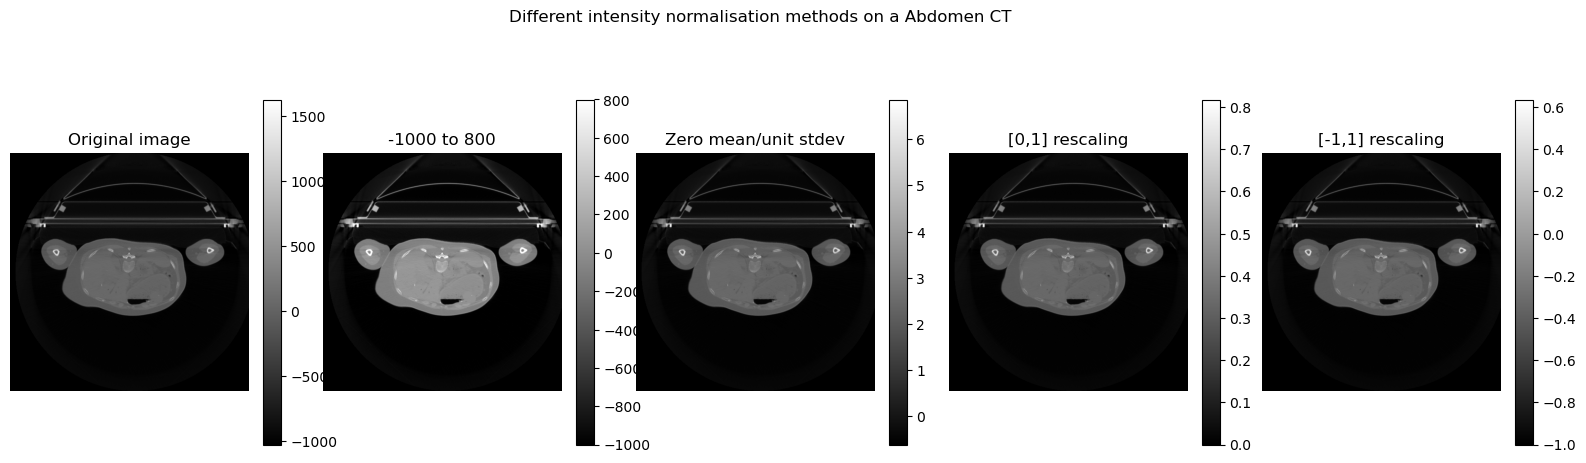

In [8]:
f, axarr = plt.subplots(1, 5, figsize=(20,5));
f.suptitle('Different intensity normalisation methods on a Abdomen CT')

img = axarr[0].imshow(np.squeeze(image[100, :, :]), cmap='gray',origin='lower');
axarr[0].axis('off')
axarr[0].set_title('Original image')
f.colorbar(img, ax=axarr[0])

img = axarr[1].imshow(np.squeeze(Normalize_minun100_to_800hu[100, :, :]), cmap='gray',origin='lower');
axarr[1].axis('off')
axarr[1].set_title('-1000 to 800')
f.colorbar(img, ax=axarr[1])

img = axarr[2].imshow(np.squeeze(Normalize_0mean_UnitVr[100, :, :]), cmap='gray',origin='lower');
axarr[2].axis('off')
axarr[2].set_title('Zero mean/unit stdev')
f.colorbar(img, ax=axarr[2])

img = axarr[3].imshow(np.squeeze(Normalize_0to1[100, :, :]), cmap='gray',origin='lower');
axarr[3].axis('off')
axarr[3].set_title('[0,1] rescaling')
f.colorbar(img, ax=axarr[3])

img = axarr[4].imshow(np.squeeze(normalise_minus1_to1[100, :, :]), cmap='gray',origin='lower');
axarr[4].axis('off')
axarr[4].set_title('[-1,1] rescaling')
f.colorbar(img, ax=axarr[4])
    
f.subplots_adjust(wspace=0.05, hspace=0, top=0.8)
plt.show();

CT Shape Original=(148, 512, 512), Resampled to 1mm=(444, 700, 700)
CT Mask Shape=(148, 512, 512), Resampled to 1mm=(444, 700, 700)


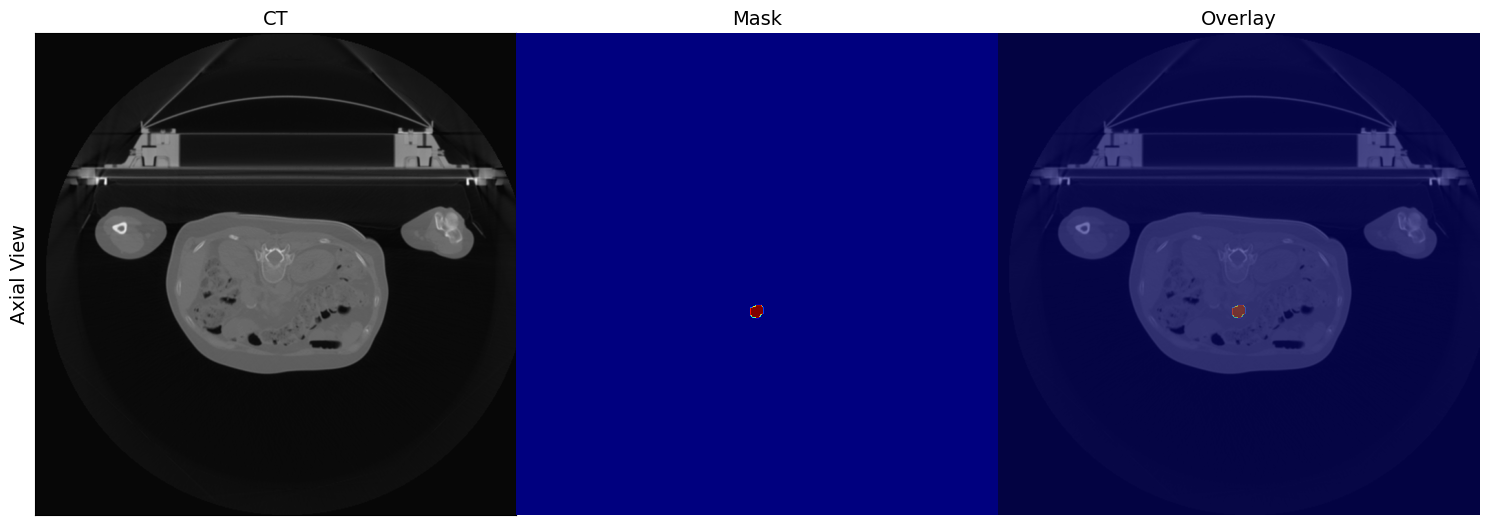

In [9]:
def resample_img(itk_image, out_spacing=[2.0, 2.0, 2.0], is_label=False):
    # resample images to 2mm spacing with simple itk

    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)


ct_resampled_to1m=resample_img(img_sitk, out_spacing=[1, 1, 1], is_label=False)
ct_resampled_to1m=sitk.GetArrayFromImage(ct_resampled_to1m)
mask_resampled_to1m=resample_img(mask_sitk, out_spacing=[1, 1, 1], is_label=True)
mask_resampled_to1m=sitk.GetArrayFromImage(mask_resampled_to1m)
print('CT Shape Original={}, Resampled to 1mm={}'.format(image.shape,ct_resampled_to1m.shape))
print('CT Mask Shape={}, Resampled to 1mm={}'.format(mask.shape,mask_resampled_to1m.shape))

#----Lets plot 
f, axarr = plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(np.squeeze(ct_resampled_to1m[250, :, :]), cmap='gray',origin='lower');
axarr[0].set_ylabel('Axial View',fontsize=14)
axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[0].set_title('CT',fontsize=14)

axarr[1].imshow(np.squeeze(mask_resampled_to1m[250, :, :]), cmap='jet',origin='lower');
axarr[1].axis('off')
axarr[1].set_title('Mask',fontsize=14)

axarr[2].imshow(np.squeeze(ct_resampled_to1m[250, :, :]), cmap='gray',alpha=1,origin='lower');
axarr[2].imshow(np.squeeze(mask_resampled_to1m[250, :, :]),cmap='jet',alpha=0.5,origin='lower');
axarr[2].axis('off')
axarr[2].set_title('Overlay',fontsize=14)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

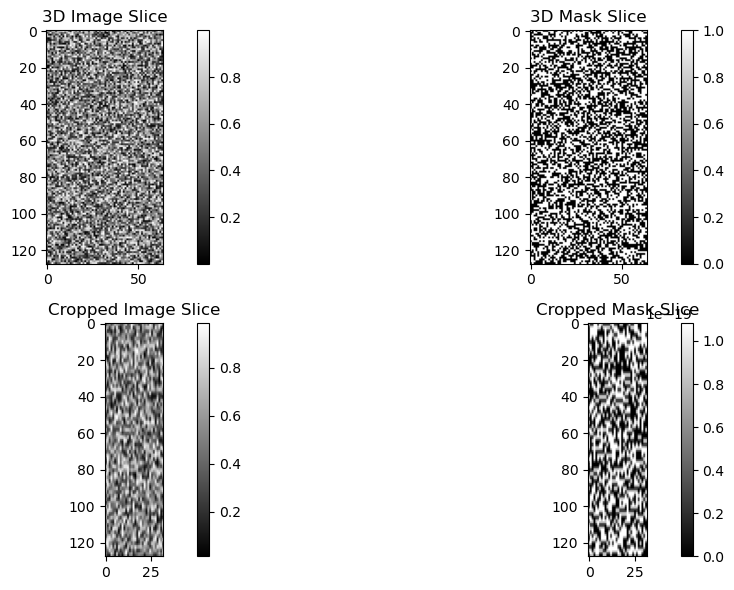

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

# Replace 'image' and 'mask' with your 3D medical image and mask data
image = np.random.rand(128, 128, 64)  # Example 3D image data
mask = np.random.randint(0, 2, size=(128, 128, 64))  # Example 3D binary mask data

# Specify the slice index you want to visualize
slice_index = 32  # Change this to the desired slice index

# Plot the original 3D image and mask
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.imshow(image[slice_index, :, :], cmap='gray')  # Image
plt.title("3D Image Slice")
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(mask[slice_index, :, :], cmap='gray')  # Mask
plt.title("3D Mask Slice")
plt.colorbar()

# Crop the image and mask to a smaller size for visualization
cropped_image = image[:, 32:96, 32:96]
cropped_mask = mask[:, 32:96, 32:96]

# Resize the cropped image for better visibility
desired_size = (128, 128)
cropped_image = resize(cropped_image, desired_size, mode='constant')
cropped_mask = resize(cropped_mask, desired_size, mode='constant')

plt.subplot(2, 2, 3)
plt.imshow(cropped_image[slice_index, :, :], cmap='gray')  # Cropped Image
plt.title("Cropped Image Slice")
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(cropped_mask[slice_index, :, :], cmap='gray')  # Cropped Mask
plt.title("Cropped Mask Slice")
plt.colorbar()

plt.tight_layout()
plt.show()


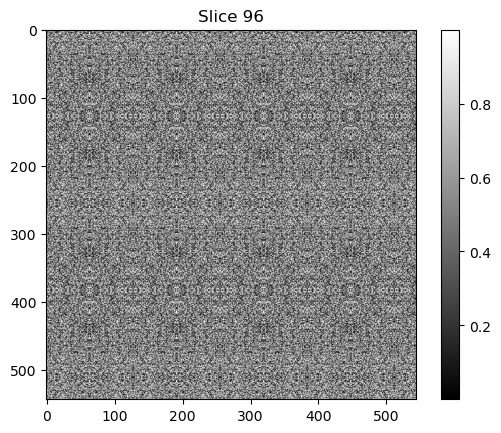

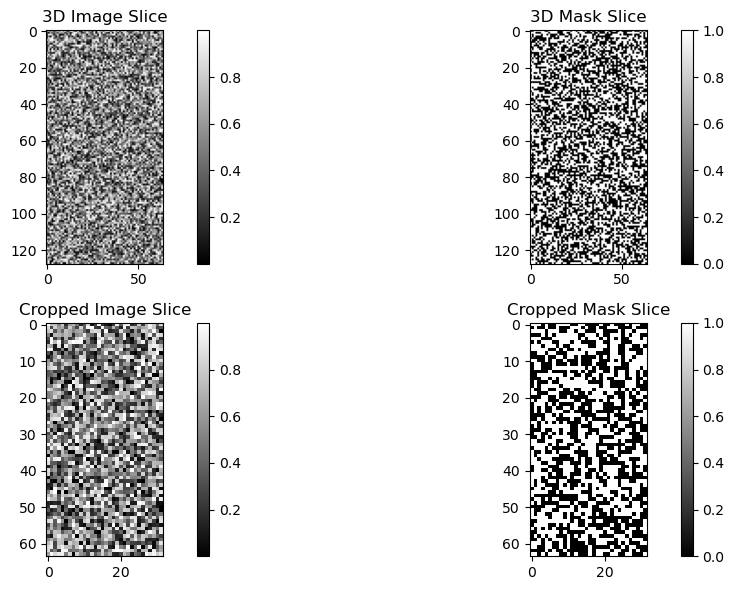

In [17]:
img_cropped = image[:96, :96, :96]
import numpy as np

desired_shape = (256, 544, 544)  # The shape you want to pad to
padded_image = np.pad(image, [(0, d - s) if d > s else (0, 0) for s, d in zip(image.shape, desired_shape)], mode='symmetric')
import numpy as np
import matplotlib.pyplot as plt

# Replace 'padded_image' with your 3D medical image data
image_data = padded_image  # Modify this to use your image data

# Specify the slice you want to visualize
slice_index = 96  # Change this to the desired slice index

# Plot the 2D slice
plt.imshow(image_data[slice_index, :, :], cmap='gray')  # Assuming a grayscale image
plt.title(f"Slice {slice_index}")
plt.colorbar()
plt.show()
import numpy as np
import matplotlib.pyplot as plt

# Replace 'image' and 'mask' with your 3D medical image and mask data
image = np.random.rand(128, 128, 64)  # Example 3D image data
mask = np.random.randint(0, 2, size=(128, 128, 64))  # Example 3D binary mask data

# Specify the slice index you want to visualize
slice_index = 32  # Change this to the desired slice index

# Plot the original 3D image and mask
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.imshow(image[slice_index, :, :], cmap='gray')  # Image
plt.title("3D Image Slice")
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(mask[slice_index, :, :], cmap='gray')  # Mask
plt.title("3D Mask Slice")
plt.colorbar()

# Crop the image and mask to a smaller size for visualization
cropped_image = image[:, 32:96, 32:96]
cropped_mask = mask[:, 32:96, 32:96]

plt.subplot(2, 2, 3)
plt.imshow(cropped_image[slice_index, :, :], cmap='gray')  # Cropped Image
plt.title("Cropped Image Slice")
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(cropped_mask[slice_index, :, :], cmap='gray')  # Cropped Mask
plt.title("Cropped Mask Slice")
plt.colorbar()

plt.tight_layout()
plt.show()




In [10]:
def resize_image_with_crop_or_pad(image, img_size=(64, 64, 64), **kwargs):
    """Image resizing. Resizes image by cropping or padding dimension
     to fit specified size.
    Args:
        image (np.ndarray): image to be resized
        img_size (list or tuple): new image size
        kwargs (): additional arguments to be passed to np.pad
    Returns:
        np.ndarray: resized image
    """

    assert isinstance(image, (np.ndarray, np.generic))
    assert (image.ndim - 1 == len(img_size) or image.ndim == len(img_size)), \
        'Example size doesnt fit image size'

    # Get the image dimensionality
    rank = len(img_size)

    # Create placeholders for the new shape
    from_indices = [[0, image.shape[dim]] for dim in range(rank)]
    to_padding = [[0, 0] for dim in range(rank)]

    slicer = [slice(None)] * rank

    # For each dimensions find whether it is supposed to be cropped or padded
    for i in range(rank):
        if image.shape[i] < img_size[i]:
            to_padding[i][0] = (img_size[i] - image.shape[i]) // 2
            to_padding[i][1] = img_size[i] - image.shape[i] - to_padding[i][0]
        else:
            from_indices[i][0] = int(np.floor((image.shape[i] - img_size[i]) / 2.))
            from_indices[i][1] = from_indices[i][0] + img_size[i]

        # Create slicer object to crop or leave each dimension
        slicer[i] = slice(from_indices[i][0], from_indices[i][1])

    # Pad the cropped image to extend the missing dimension
    return np.pad(image[slicer], to_padding, **kwargs)


# Crop to [64, 64, 64]
img_cropped = resize_image_with_crop_or_pad(image, [64, 64, 64], mode='symmetric')

# Resizing image to [128, 256, 256] required padding
img_padded = resize_image_with_crop_or_pad(image, [128, 5, 544], mode='symmetric')

# Visualise using matplotlib.
f, axarr = plt.subplots(1, 3, figsize=(15,15));
axarr[0].imshow(np.squeeze(image[100, :, :]), cmap='gray',origin='lower');
axarr[0].axis('off')
axarr[0].set_title('Original image {}'.format(image.shape))

axarr[1].imshow(np.squeeze(img_cropped[32, :, :]), cmap='gray',origin='lower');
axarr[1].axis('off')
axarr[1].set_title('Cropped to {}'.format(img_cropped.shape))

axarr[2].imshow(np.squeeze(img_padded[140, :, :]), cmap='gray',origin='lower');
axarr[2].axis('off')
axarr[2].set_title('Padded to {}'.format(img_padded.shape))
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [2]:
def histogram_matching(mov_scan, ref_scan,
                       histogram_levels=2048,
                       match_points=100,
                       set_th_mean=True):
    """
    Histogram matching following the method developed on
    Nyul et al 2001 (ITK implementation)
    inputs:
    - mov_scan: np.array containing the image to normalize
    - ref_scan np.array containing the reference image
    - histogram levels
    - number of matched points
    - Threshold Mean setting
    outputs:
    - histogram matched image
    """

    # convert np arrays into itk image objects
    ref = sitk.GetImageFromArray(ref_scan.astype('float32'))
    mov = sitk.GetImageFromArray(mov_scan.astype('float32'))

    # perform histogram matching
    caster = sitk.CastImageFilter()
    caster.SetOutputPixelType(ref.GetPixelID())

    matcher = sitk.HistogramMatchingImageFilter()
    matcher.SetNumberOfHistogramLevels(histogram_levels)
    matcher.SetNumberOfMatchPoints(match_points)
    matcher.SetThresholdAtMeanIntensity(set_th_mean)
    matched_vol = matcher.Execute(mov, ref)

    return matched_vol

In [3]:
import SimpleITK as sitk
import os
from os import listdir
from os.path import isfile, join
import glob
import numpy as np

'''
This function was deigned to Give MIP for two label Left and Right Lung.
if you have your own labels change or introduce for label indexes based on your need. 
Otherwise if you don't have labels set give_onlysegmented_data=False ony want to MIP between slices indicate the within how many slices it should count.
'''

def MIP_onrun(img,lbl,slices_num,give_onlysegmented_data=True):

    """ Performed maximum instensity projection.

    Args:
        image (np.ndarray): image to perform mip
        label (np.ndarray): labels to use for extraxting classes the classes
        slices_num(int):

    Returns:
        Returned maximum intensity projected ndarray.
        give_onlysegmented_data=True, returns only the segmented Regions.

    """
    img_flatten=img.flatten()
    lbl_flatten=lbl.flatten()
    img_new=img.flatten()

    ###Getting the Index for Right and Left Lung

    idx_rl = np.argwhere(lbl_flatten == 2.0)
    idx_ll = np.argwhere(lbl_flatten == 3.0)

    #print(len(idx_rl))
    #print(len(idx_ll))

    idx_Index_1=np.argwhere(lbl_flatten<2)
    #print(len(idx_Index_1))
    idx_3up=np.argwhere(lbl_flatten>3)
    #print(len(idx_3up))

    ###########Removing all other labels
    img_new[idx_Index_1]=0.0
    img_new[idx_3up]=0.0

    img_new_reshape=np.reshape(img_new,img.shape)


    def createMIP(np_img, slices_num):
        ''' create the mip image from original image, slice_num is the number of
        slices for maximum intensity projection'''
        img_shape = np_img.shape
        np_mip = np.zeros(img_shape)
        for i in range(img_shape[0]):
            start = max(0, i-slices_num)
            np_mip[i,:,:] = np.amax(np_img[start:i+1],0)
        return np_mip

    np_mip = createMIP(img_new_reshape,slices_num=slices_num)

    if give_onlysegmented_data is True:

       final_img=np_mip
    else:

        np_mip_flatten=np_mip.flatten()
        np_mip_flatten[idx_Index_1]=img_flatten[idx_Index_1]
        np_mip_flatten[idx_3up]=img_flatten[idx_3up]

        final_img=np.reshape(np_mip_flatten,np_mip.shape)

    return final_img

In [20]:
import os
import glob
import monai
import torch
import numpy as np 
from PIL import Image
from tqdm import tqdm
import SimpleITK as sitk
from statistics import mean
from torch.optim import Adam
from natsort import natsorted
import matplotlib.pyplot as plt
from transformers import SamModel 
import matplotlib.patches as patches
from transformers import SamProcessor
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import threshold, normalize

%matplotlib inline

from monai.transforms import (
    EnsureChannelFirstd,
    EnsureTyped,
    Compose,
    CropForegroundd,
    CopyItemsd,
    LoadImaged,
    CenterSpatialCropd,
    Invertd,
    OneOf,
    Orientationd,
    MapTransform,
    NormalizeIntensityd,
    RandSpatialCropSamplesd,
    CenterSpatialCropd,
    RandSpatialCropd,
    SpatialPadd,
    ScaleIntensityRanged,
    Spacingd,
    RepeatChanneld,
    ToTensord,
)

ImportError: cannot import name 'SamModel' from 'transformers' (/home/bori/miniconda3/envs/sam_adapt/lib/python3.10/site-packages/transformers/__init__.py)

In [19]:
!pip install natsort

In [ ]:
data_dir = '/content/3d_images'
images = sorted(
    glob.glob(os.path.join(data_dir, "IMG*.nii.gz")))
labels = sorted(
    glob.glob(os.path.join(data_dir, "MASK*.nii.gz")))

print('No. of images:', len(images), ' labels:', len(labels))

In [21]:
ct_path='/home/bori/segmentation-pancreas-post-operative/nnUNetFrame/dataset/nnUNet_raw/Dataset001_Postoperative/imagesTr/Image_Recidief1_0000.nii.gz'
ct_label_path='/home/bori/segmentation-pancreas-post-operative/nnUNetFrame/dataset/nnUNet_raw/Dataset001_Postoperative/labelsTr/Image_Recidief1.nii.gz'
data_dicts = [{"image":ct_path, "label": ct_label_path} for image_name, label_name in zip(images, labels)]
# how to make my image and mask like this data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
#train_files, val_files = data_dicts[:-9], data_dicts[-9:]



# Assuming first 2 patients for training, next 1 for validation and last 1 for testing
for idx, (img_path, mask_path) in enumerate(zip(images, labels)):
    # Load the 3D image and mask
    img = sitk.ReadImage(img_path)
    mask = sitk.ReadImage(mask_path)

In [ ]:
base_dir='/home/bori/segmentation-pancreas-post-operative/nnUNetFrame/dataset/nnUNet_raw/Dataset001_Postoperative/'
datasets = ['train', 'val', 'test']
data_types = ['2d_images', '2d_masks']

# Create directories
dir_paths = {}
for dataset in datasets:
    for data_type in data_types:
        # Construct the directory path
        dir_path = os.path.join(base_dir, f'{dataset}_{data_type}')
        dir_paths[f'{dataset}_{data_type}'] = dir_path
        # Create the directory
        os.makedirs(dir_path, exist_ok=True)

# Assuming first 2 patients for training, next 1 for validation and last 1 for testing
for idx, (img_path, mask_path) in enumerate(zip(images, labels)):
    # Load the 3D image and mask
    img = sitk.ReadImage(img_path)
    mask = sitk.ReadImage(mask_path)

    print('processing patient', idx, img.GetSize(), mask.GetSize())

    # Get the mask data as numpy array
    mask_data = sitk.GetArrayFromImage(mask)

    # Select appropriate directories
    if idx < 2:  # Training
        img_dir = dir_paths['train_2d_images']
        mask_dir = dir_paths['train_2d_masks']
    elif idx == 2:  # Validation
        img_dir = dir_paths['val_2d_images']
        mask_dir = dir_paths['val_2d_masks']
    else:  # Testing
        img_dir = dir_paths['test_2d_images']
        mask_dir = dir_paths['test_2d_masks']

    # Iterate over the axial slices
    for i in range(img.GetSize()[0]):
        # If the mask slice is not empty, save the image and mask slices

        if np.any(mask_data[i, :, :]):
            # Prepare the new ITK images
            img_slice = img[i, :, :]
            mask_slice = mask[i, :, :]
            
            # Define the output paths
            img_slice_path = os.path.join(img_dir, f"{os.path.basename(img_path).replace('.nii.gz', '')}_{i}.nii.gz")
            mask_slice_path = os.path.join(mask_dir, f"{os.path.basename(mask_path).replace('.nii.gz', '')}_{i}.nii.gz")

            # Save the slices as NIfTI files
            sitk.WriteImage(img_slice, img_slice_path)
            sitk.WriteImage(mask_slice, mask_slice_path)


In [1]:
image_path = '/home/bori/segmentation-pancreas-post-operative/nnUNetFrame/dataset/nnUNet_raw/Dataset001_Postoperative/imageTr/Image_Recidief1_0000.nii.gz'
ct_label_path = '/home/bori/segmentation-pancreas-post-operative/nnUNetFrame/dataset/nnUNet_raw/Dataset001_Postoperative/labelsTr/Image_Recidief1.nii.gz'


In [3]:
import nibabel as nib
import os
image_data = nib.load(image_path).get_fdata()
image_tensor = torch.tensor(image_data).unsqueeze(0).float()

FileNotFoundError: No such file or no access: '/home/bori/segmentation-pancreas-post-operative/nnUNetFrame/dataset/nnUNet_raw/Dataset001_Postoperative/imageTr/Image_Recidief1_0000.nii.gz'

In [1]:
import torch


# Assuming you have your image tensor
image_tensor = torch.randn(1, 148, 128, 128)  # Replace with your actual image tensor

# Get the shape of the original tensor
original_shape = image_tensor.shape

# Select slices with odd indices along the depth axis
selected_slices = image_tensor[:, 1::2, :, :]

# Get the shape of the selected slices
selected_slices_shape = selected_slices.shape

# Print the shapes for verification
print("Original Shape:", original_shape)
print("Selected Slices Shape:", selected_slices_shape)


Original Shape: torch.Size([1, 148, 128, 128])
Selected Slices Shape: torch.Size([1, 74, 128, 128])


/gpu_home/bori/miniconda3/envs/sam_adapt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from monai.transforms import Compose, LoadImageD, EnsureChannelFirstD, ScaleIntensityD, SpacingD, \
    ToTensorD, ThresholdIntensityD, OrientationD, RandCropByPosNegLabelD, CropForegroundD, apply_transform
import torch
import numpy as np
import re
import matplotlib.pyplot as plt
import os
class PostopPancreas(Dataset):
    def __init__(self, data_path, mode='Training', prompt='click'):
        self.data_path = os.path.join(data_path, "nnUNet_raw", "Dataset001_Postoperative")
        self.image_path = os.path.join(self.data_path, "imagesTr")
        self.label_path = os.path.join(self.data_path, "labelsTr")
        self.mode = mode
        self.prompt = prompt
        img_resolution = 128  # Set the new image resolution


        all_image_files = [f for f in os.listdir(self.image_path) if f.endswith('.nii.gz')]
        all_image_files.sort()

        if self.mode == 'Training':
            self.image_files = [f for f in all_image_files if int(re.search(r"\d+", f).group(0)) <= 10]
        else:
            self.image_files = [f for f in all_image_files if int(re.search(r"\d+", f).group(0)) > 10]

        self.label_files = [f.replace('_0000.nii.gz', '.nii.gz') for f in self.image_files]
        self.label_files.sort()
    
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_filename = self.image_files[index]
        label_filename = self.label_files[index]

        image_filepath = os.path.join(self.image_path, image_filename)
        label_filepath = os.path.join(self.label_path, label_filename)

        image_data = nib.load(image_filepath).get_fdata()
        label_data = nib.load(label_filepath).get_fdata()

        image_tensor = torch.tensor(image_data, dtype=torch.float32).unsqueeze(0)  # Adding channel dimension
        label_tensor = torch.tensor(label_data, dtype=torch.float32).unsqueeze(0)  # Adding channel dimension

        
        # Pad image and label tensors to a common size

        # Adjust for channel dimension
        # img = img.unsqueeze(0)
        # mask = mask.unsqueeze(0)

        max_depth, max_height, max_width = self.get_max_dimensions()
        img = self.pad_tensor(img, max_depth, max_height, max_width)
        mask = self.pad_tensor(mask, max_depth, max_height, max_width)

       
        img = self.resize_tensor(img)
        mask = self.resize_tensor(mask)

        #select only the odd slices of imagers and masks and make the depth half
        #img = img[:, 1::2, :, :]
        #print(img.shape)
        #mask = mask[:, 1::2, :, :]
        #print(mask.shape)

        #select only the even slices of imagers and masks and make the depth half
        # img = img[:, ::2, :, :]
        # print(img.shape)
        # mask = mask[:, ::2, :, :]
        # print(mask.shape)
        

        image_meta_dict = {'filename_or_obj': self.image_files[index].replace('.npy', '')}
        return {
            'image': img,
            'label': mask,
            'p_label':1,
            'image_meta_dict': image_meta_dict,
        }

    def resize_tensor(self, tensor):
        # Calculate proportional depth
        _, original_depth, original_height, _ = tensor.shape
        new_depth = 148  # The new depth you want

    # Calculate the scaling factors for height and width
        scale_factor_height = 128 / 518
        scale_factor_width = 128 / 518

    # Resize the tensor
        tensor = tensor.unsqueeze(0)
        tensor = functional.interpolate(tensor, size=(new_depth, 128, 128), mode='trilinear', align_corners=True)
        return tensor.squeeze(0)

    

    def get_max_dimensions(self):
        max_depth, max_height, max_width = 0, 0, 0
        for image_filename in self.image_files:  # <- Change made here
            image_filepath = os.path.join(self.data_path, image_filename)
            image_data = np.load(image_filepath)  # Loading .npy file
            _, depth, height, width = image_data.shape
            max_depth = max(max_depth, depth)
            max_height = max(max_height, height)
            max_width = max(max_width, width)
        return max_depth, max_height, max_width

    @staticmethod
    def pad_tensor(tensor, max_depth, max_height, max_width):
        depth, height, width = tensor.shape[-3:]
        pad_depth = max_depth - depth
        pad_height = max_height - height
        pad_width = max_width - width

        # Padding format: (left, right, top, bottom, front, back)
        padding = (0, pad_width, 0, pad_height, 0, pad_depth)
        return pad(tensor, padding, mode='constant', value=0)





In [ ]:
import re

class PostopPancreasRaw(Dataset):
    def __init__(self, data_path, mode='Training', prompt='click'):
        self.data_path = os.path.join(data_path, "nnUNet_raw", "Dataset001_Postoperative")
        self.image_path = os.path.join(self.data_path, "imagesTr")
        self.label_path = os.path.join(self.data_path, "labelsTr")
        self.mode = mode
        self.image_label_paths = {} # Dictionary to store image and label paths
        self.prompt = prompt

        


        all_image_files = [f for f in os.listdir(self.image_path) if f.endswith('.nii.gz')]
        all_image_files.sort()

        if self.mode == 'Training':
            self.image_files = [f for f in all_image_files if int(re.search(r"\d+", f).group(0)) <= 10]
        else:
            self.image_files = [f for f in all_image_files if int(re.search(r"\d+", f).group(0)) > 10]

        self.label_files = [f.replace('_0000.nii.gz', '.nii.gz') for f in self.image_files]
        self.label_files.sort()

        # Store image and label paths in the dictionary
        self.image_label_paths[self.mode] = {'image': self.image_files, 'label': self.label_files}


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_filename = self.image_files[index]
        label_filename = self.label_files[index]

        image_filepath = os.path.join(self.image_path, image_filename)
        label_filepath = os.path.join(self.label_path, label_filename)

        image_data = nib.load(image_filepath).get_fdata()
        label_data = nib.load(label_filepath).get_fdata()

        image_tensor = torch.tensor(image_data, dtype=torch.float32).unsqueeze(0)  # Adding channel dimension
        label_tensor = torch.tensor(label_data, dtype=torch.float32).unsqueeze(0)  # Adding channel dimension

        # For prompt, we need to decide what strategy to use for 3D data.
        # Here, we're just using a simple strategy by picking a random point in the volume.


        image_meta_dict = {'filename_or_obj': image_filename}

        return {
            'image': image_tensor,
            'label': label_tensor,
            'p_label': 1,  # Just a placeholder
            'image_meta_dict': image_meta_dict
        }
    



    def get_max_dimensions(self):
        max_depth, max_height, max_width = 0, 0, 0
        for image_filename in self.image_files:
            image_filepath = os.path.join(self.image_path, image_filename)
            image_data = nib.load(image_filepath).get_fdata()
            depth, height, width = image_data.shape
            max_depth = max(max_depth, depth)
            max_height = max(max_height, height)
            max_width = max(max_width, width)
        return max_depth, max_height, max_width

    @staticmethod
    def pad_tensor(tensor, max_depth, max_height, max_width):
        depth, height, width = tensor.shape[-3:]
        pad_depth = max_depth - depth
        pad_height = max_height - height
        pad_width = max_width - width

        # Padding format: (left, right, top, bottom, front, back)
        padding = (0, pad_width, 0, pad_height, 0, pad_depth)
        return pad(tensor, padding, mode='constant', value=0)




In [ ]:
def get_bounding_box(ground_truth_map):
    '''
    This function creates varying bounding box coordinates based on the segmentation contours as prompt for the SAM model
    The padding is random int values between 5 and 20 pixels
    '''

    if len(np.unique(ground_truth_map)) > 1:

        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(5, 20))
        x_max = min(W, x_max + np.random.randint(5, 20))
        y_min = max(0, y_min - np.random.randint(5, 20))
        y_max = min(H, y_max + np.random.randint(5, 20))
        
        bbox = [x_min, y_min, x_max, y_max]

        return bbox
    else:
        return [0, 0, 256, 256] # if there is no mask in the array, set bbox to image size
        





class SAMDataset(Dataset):
    def __init__(self, image_paths, mask_paths, processor):
        
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.processor = processor
        self.transforms = transforms = Compose([
            
            # load .nii or .nii.gz files
            LoadImaged(keys=['img', 'label']),
            
            # add channel id to match PyTorch configurations
            EnsureChannelFirstd(keys=['img', 'label']),
            
            # reorient images for consistency and visualization
            Orientationd(keys=['img', 'label'], axcodes='RA'),
            
            # resample all training images to a fixed spacing
            Spacingd(keys=['img', 'label'], pixdim=(1.5, 1.5), mode=("bilinear", "nearest")),
            
            # rescale image and label dimensions to 256x256 
            CenterSpatialCropd(keys=['img', 'label'], roi_size=(256,256)),
            
            # scale intensities to 0 and 255 to match the expected input intensity range
            ScaleIntensityRanged(keys=['img'], a_min=-1000, a_max=2000, 
                         b_min=0.0, b_max=255.0, clip=True), 
            
            ScaleIntensityRanged(keys=['label'], a_min=0, a_max=255, 
                         b_min=0.0, b_max=1.0, clip=True), 

            SpatialPadd(keys=["img", "label"], spatial_size=(256,256))
#             RepeatChanneld(keys=['img'], repeats=3, allow_missing_keys=True)
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        # create a dict of images and labels to apply Monai's dictionary transforms
        data_dict = self.transforms({'img': image_path, 'label': mask_path})

        # squeeze extra dimensions
        image = data_dict['img'].squeeze()
        ground_truth_mask = data_dict['label'].squeeze()

        # convert to int type for huggingface's models expected inputs
        image = image.astype(np.uint8)

        # convert the grayscale array to RGB (3 channels)
        array_rgb = np.dstack((image, image, image))
        
        # convert to PIL image to match the expected input of processor
        image_rgb = Image.fromarray(array_rgb)
        
        # get bounding box prompt (returns xmin, ymin, xmax, ymax)
        # in this dataset, the contours are -1 so we change them to 1 for label and 0 for background
        ground_truth_mask[ground_truth_mask < 0] = 1
        
        prompt = get_bounding_box(ground_truth_mask)
        
        # prepare image and prompt for the model
        inputs = self.processor(image_rgb, input_boxes=[[prompt]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # add ground truth segmentation (ground truth image size is 256x256)
        inputs["ground_truth_mask"] = torch.from_numpy(ground_truth_mask.astype(np.int8))

        return inputs

In [4]:
ct_path='/home/bori/segmentation-pancreas-post-operative/nnUNetFrame/dataset/nnUNet_raw/Dataset001_Postoperative/imagesTr/Image_Recidief1_0000.nii.gz'
ct_label_path='/home/bori/segmentation-pancreas-post-operative/nnUNetFrame/dataset/nnUNet_raw/Dataset001_Postoperative/labelsTr/Image_Recidief1.nii.gz'
data_dicts = [{"image":ct_path, "label": ct_label_path}]
train_files = data_dicts[0]




{'image': '/home/bori/segmentation-pancreas-post-operative/nnUNetFrame/dataset/nnUNet_raw/Dataset001_Postoperative/imagesTr/Image_Recidief1_0000.nii.gz',
 'label': '/home/bori/segmentation-pancreas-post-operative/nnUNetFrame/dataset/nnUNet_raw/Dataset001_Postoperative/labelsTr/Image_Recidief1.nii.gz'}

In [8]:
img,lab=LoadImaged(keys=[data_dicts[0][0], data_dicts[0][1]])

KeyError: 0

In [5]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)

/gpu_home/bori/miniconda3/envs/sam_adapt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/gpu_home/bori/miniconda3/envs/sam_adapt/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [7]:
import os
from glob import glob
data_path='/gpu_home/bori/segmentation-pancreas-post-operative/nnUNetFrame/dataset'
data_path = os.path.join(data_path, "nnUNet_raw", "Dataset001_Postoperative")
image_path =sorted(glob(os.path.join(data_path, "imagesTr", '*.nii.gz')))
label_path =sorted(glob (os.path.join(data_path, "labelsTr", '*.nii.gz')))

train_images =sorted(glob(os.path.join(data_path, "imagesTr", '*.nii.gz')))
train_labels =sorted(glob (os.path.join(data_path, "labelsTr", '*.nii.gz')))
train_labels
train_files = [{"image": image_name, "label":label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files

[{'image': '/gpu_home/bori/segmentation-pancreas-post-operative/nnUNetFrame/dataset/nnUNet_raw/Dataset001_Postoperative/imagesTr/Image_Recidief10_0000.nii.gz',
  'label': '/gpu_home/bori/segmentation-pancreas-post-operative/nnUNetFrame/dataset/nnUNet_raw/Dataset001_Postoperative/labelsTr/Image_Recidief1.nii.gz'},
 {'image': '/gpu_home/bori/segmentation-pancreas-post-operative/nnUNetFrame/dataset/nnUNet_raw/Dataset001_Postoperative/imagesTr/Image_Recidief11_0000.nii.gz',
  'label': '/gpu_home/bori/segmentation-pancreas-post-operative/nnUNetFrame/dataset/nnUNet_raw/Dataset001_Postoperative/labelsTr/Image_Recidief10.nii.gz'},
 {'image': '/gpu_home/bori/segmentation-pancreas-post-operative/nnUNetFrame/dataset/nnUNet_raw/Dataset001_Postoperative/imagesTr/Image_Recidief12_0000.nii.gz',
  'label': '/gpu_home/bori/segmentation-pancreas-post-operative/nnUNetFrame/dataset/nnUNet_raw/Dataset001_Postoperative/labelsTr/Image_Recidief11.nii.gz'},
 {'image': '/gpu_home/bori/segmentation-pancreas-post

In [12]:
from monai.transforms import (
   Activations,
   #AsChannelFirstd,
   AsDiscrete,
   CenterSpatialCropd,
   Compose,
   LoadImaged,
   MapTransform,
   NormalizeIntensityd,
   Orientationd,
   RandFlipd,
   RandScaleIntensityd,
   RandShiftIntensityd,
   RandSpatialCropd,
   Spacingd,
   ToTensord,
)
roi_size=[128, 128, 64]
pixdim=(1.5, 1.5, 2.0)

train_transform = Compose(
   [
       # load 4 Nifti images and stack them together
       LoadImaged(keys=["image", "label"]),
       #ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
       Spacingd(
           keys=["image", "label"],
           pixdim=pixdim,
           mode=("bilinear", "nearest"),
       ),
       Orientationd(keys=["image", "label"], axcodes="RAS"),
       RandSpatialCropd(
           keys=["image", "label"], roi_size=roi_size, random_size=False),
       RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
       NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
       RandScaleIntensityd(keys="image", factors=0.1, prob=0.5),
       RandShiftIntensityd(keys="image", offsets=0.1, prob=0.5),
       ToTensord(keys=["image", "label"])
   ]
)


In [ ]:
ct_path='/home/bori/segmentation-pancreas-post-operative/nnUNetFrame/dataset/nnUNet_raw/Dataset001_Postoperative/imagesTr/Image_Recidief1_0000.nii.gz'
ct_label_path='/home/bori/segmentation-pancreas-post-operative/nnUNetFrame/dataset/nnUNet_raw/Dataset001_Postoperative/labelsTr/Image_Recidief1.nii.gz'
data_dicts = [{"image":ct_path, "label": ct_label_path}]
train_files = data_dicts[0]



In [26]:
from monai.transforms import Compose, LoadImageD, EnsureChannelFirstD, OrientationD, \
    ThresholdIntensityD, ScaleIntensityD, SpacingD, CropForegroundD, ToTensorD
from monai.data import Dataset, DataLoader
import nibabel as nib
import numpy as np
from monai.data import CacheDataset, DataLoader, NibabelReader, pad_list_data_collate, partition_dataset, \
    partition_dataset_classes, select_cross_validation_folds
# Define the keys
keys = ('image', 'label')

# Define your label spacing, reader, and other parameters
label_spacing = 'nearest'  # Replace with your value
d = 64  # Replace with your value

# Define your data augmentation transforms
data_augmentation_transforms = Compose([
    # Add your data augmentation transforms here
])

# Define the discretize_labels transform
discretize_labels = Compose([
    # Add your discretize_labels transforms here
])

# Create the MONAI Compose object
transform = Compose([
    LoadImageD(keys, reader=NibabelReader()),
    EnsureChannelFirstD(keys),
    OrientationD(keys, axcodes='RAS'),
    ThresholdIntensityD(keys[0], threshold=-100, above=True, cval=-100),
    ThresholdIntensityD(keys[0], threshold=240, above=False, cval=240),
    ScaleIntensityD(keys[0]),
    SpacingD(keys, pixdim=(1., 1., 1.), mode=('bilinear', label_spacing)),
    CropForegroundD(
        keys,
        source_key='label',
        select_fn=lambda x: np.full(shape=x.shape, fill_value=np.any(np.any(x > 0, axis=-4), axis=(-2, -3))),
        margin=(0, 0, 10),
        k_divisible=d
    ),
    CropForegroundD(keys, source_key='image', k_divisible=64),
    discretize_labels if label_spacing == 'bilinear' else Compose([]),
    data_augmentation_transforms,
    ToTensorD(keys),
])

# Apply the transform to your images and labels
transformed_data = transform(train_files)


/gpu_home/bori/miniconda3/envs/nnunet/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [27]:
transformed_data[0]['image'].shape

torch.Size([1, 576, 448, 64])

In [25]:
import torch
train_set=Dataset(data=train_files, transform=train_transform)
train_loader = DataLoader(train_set, batch_size=1, shuffle=True, num_workers=4, pin_memory=torch.cuda.is_available())


/gpu_home/bori/miniconda3/envs/nnunet/lib/python3.10/site-packages/monai/transforms/spatial/array.py:635: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (467, 68), channels = 512,please make sure the input is in the channel-first format.
  warnings.warn(
/gpu_home/bori/miniconda3/envs/nnunet/lib/python3.10/site-packages/monai/transforms/spatial/array.py:635: UserWarning: axcodes ('RAS') length is smaller than number of input spatial dimensions D=2.
Orientation: spatial shape = (467, 135), channels = 512,please make sure the input is in the channel-first format.
  warnings.warn(


RuntimeError: applying transform <monai.transforms.compose.Compose object at 0x7f3f639b8490>

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import sys
import pickle
import cv2
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
import pandas as pd
from skimage.transform import rotate
from utils import random_click
import random
from monai.transforms import LoadImaged, Randomizable,LoadImage
from monai.data import Dataset as monaiDataset
import re
from torch.nn import functional
# prompt
from models.sam.utils.amg import build_all_layer_point_grids

import json
import nibabel as nib

import torchvision

from monai.transforms import Compose#, LoadNifti, EnsureChannelFirst, RescaleIntensity, AddChannel, ScaleIntensity, SpatialPad, SpatialCrop, Orientation, RandCropByPosNegLabel, CropForeground, ToTensor, Lambda
import os
import nibabel as nib
import json
import re
import numpy as np
import torch
from torch.utils.data import Dataset

import os
import numpy as np
import nibabel as nib
import torch
from torch.utils.data import Dataset
from torch.nn.functional import pad

from monai.apps import CrossValidation
from monai.data import CacheDataset, DataLoader, NibabelReader, pad_list_data_collate, partition_dataset, \
    partition_dataset_classes, select_cross_validation_folds
from monai.transforms import Compose, LoadImageD, EnsureChannelFirstD, ScaleIntensityD, SpacingD, \
    ToTensorD, ThresholdIntensityD, OrientationD, RandCropByPosNegLabelD, CropForegroundD, apply_transform

from monai.transforms import (
        Activations,
        #AsChannelFirstd,
        AsDiscrete,
        CenterSpatialCropd,
        Compose,
        LoadImaged,
        MapTransform,
        NormalizeIntensityd,
        Orientationd,
        RandFlipd,
        RandScaleIntensityd,
        RandShiftIntensityd,
        RandSpatialCropd,
        ResizeWithPadOrCropd,
        Spacingd,
        ToTensord,
        )
class PublicPancreasRaw(Dataset):
    def __init__(self, data_path, mode='Training', prompt='click', data_augmentation=False):
        self.data_path = os.path.join(data_path, "nnUNet_raw", "Dataset007_Pancreas")
        self.image_path = os.path.join(data_path, "imagesTr")
        self.label_path = os.path.join(data_path, "labelsTr")
        self.mode = mode
        self.prompt = prompt

        all_image_files = [f for f in os.listdir(self.image_path) if f.endswith('.nii.gz')]
        all_image_files.sort()

        if self.mode == 'Training':
            self.image_files = [f for f in all_image_files if int(re.search(r"\d+", f).group(0)) <= 200]
        else:
            self.image_files = [f for f in all_image_files if int(re.search(r"\d+", f).group(0)) > 200]

        self.label_files = [f.replace('_0000.nii.gz', '.nii.gz') for f in self.image_files]
        self.label_files.sort()

        keys = ('image', 'label')
        label_spacing = 'nearest'
        h, w, d = 128, 128, 100
        data_augmentation_transforms = Compose([
            RandCropByPosNegLabelD(keys, label_key=keys[1],
                                spatial_size=(h, w, d),
                                pos=0.5, neg=0.5, num_samples=1),
        ])

        discretize_labels = Compose([
            ThresholdIntensityD(keys[1], threshold=0.5, above=True, cval=0.0),
            ThresholdIntensityD(keys[1], threshold=0.5, above=False, cval=1.0),
        ])
        self.transform = Compose([
            LoadImageD(keys, reader=NibabelReader()),
            EnsureChannelFirstD(keys),
            OrientationD(keys, axcodes='RAS'),
            ResizeWithPadOrCropd(keys, spatial_size=(128, 128, 100)),
            ThresholdIntensityD(keys[0], threshold=-100, above=True, cval=-100),
            ThresholdIntensityD(keys[0], threshold=240, above=False, cval=240),
            ScaleIntensityD(keys[0]),
            SpacingD(keys, pixdim=(1., 1., 1.), mode=('bilinear', label_spacing)),
            CropForegroundD(
                keys,
                source_key='label',
                select_fn=lambda x: np.full(shape=x.shape, fill_value=np.any(np.any(x > 0, axis=-4), axis=(-2, -3))),
                margin=(0, 0, 10),
                k_divisible=d
            ),
            CropForegroundD(keys, source_key='image', k_divisible=100),
            discretize_labels if label_spacing == 'bilinear' else Compose([]),
            data_augmentation_transforms if (data_augmentation and self.mode == 'Training') else Compose([]),
            ResizeWithPadOrCropd(keys, spatial_size=(128, 128, 100)),
            ToTensorD(keys),
        ])
    
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_filename = self.image_files[index]
        label_filename = self.label_files[index]

        image_filepath = os.path.join(self.image_path, image_filename)
        label_filepath = os.path.join(self.label_path, label_filename)

        transformed = self.transform({
            'image': image_filepath,
            'label': label_filepath
        })

        image_meta_dict = {'filename_or_obj': image_filename}

        return {
            'image': transformed["image"],
            'label': transformed["label"],
            'p_label': 1,  # Just a placeholder
            'image_meta_dict': image_meta_dict
        }

usage: ipykernel_launcher.py [-h] -net NET [-baseline BASELINE]
                             [-seg_net SEG_NET] -mod MOD -exp_name EXP_NAME
                             [-type TYPE] [-vis VIS] [-reverse REVERSE]
                             [-pretrain PRETRAIN] [-val_freq VAL_FREQ]
                             [-gpu GPU] [-gpu_device GPU_DEVICE]
                             [-sim_gpu SIM_GPU] [-epoch_ini EPOCH_INI]
                             [-image_size IMAGE_SIZE] [-out_size OUT_SIZE]
                             [-patch_size PATCH_SIZE] [-dim DIM]
                             [-depth DEPTH] [-heads HEADS] [-mlp_dim MLP_DIM]
                             [-w W] [-b B] [-s S] [-warm WARM] [-lr LR]
                             [-uinch UINCH] [-imp_lr IMP_LR]
                             [-weights WEIGHTS] [-base_weights BASE_WEIGHTS]
                             [-sim_weights SIM_WEIGHTS]
                             [-distributed DISTRIBUTED] [-dataset DATASET]
                      

SystemExit: 2

/gpu_home/bori/miniconda3/envs/sam_adapt/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
